In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 61285257'

In [2]:
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=10)

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 22 2020   SPOC     120    61285257      0.0
  1 TESS Sector 45 2021   SPOC     120    61285257      0.0
  2 TESS Sector 46 2021   SPOC     120    61285257      0.0
  3 TESS Sector 72 2023   SPOC     120    61285257      0.0


[8842]
[8223]
[8297]
[ 2949  7538 10384]


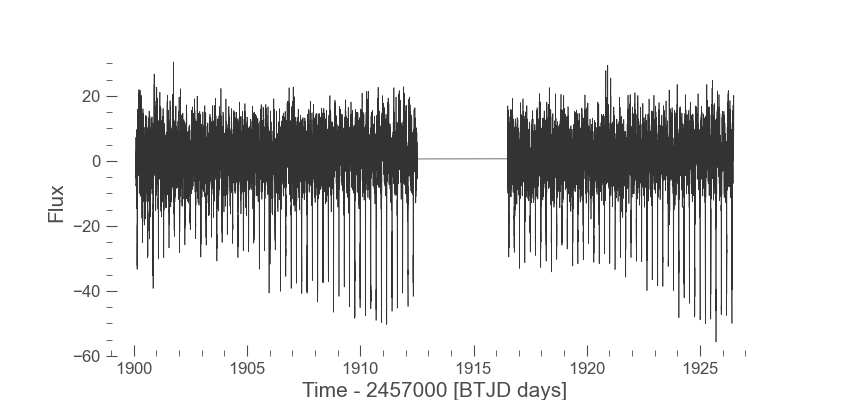

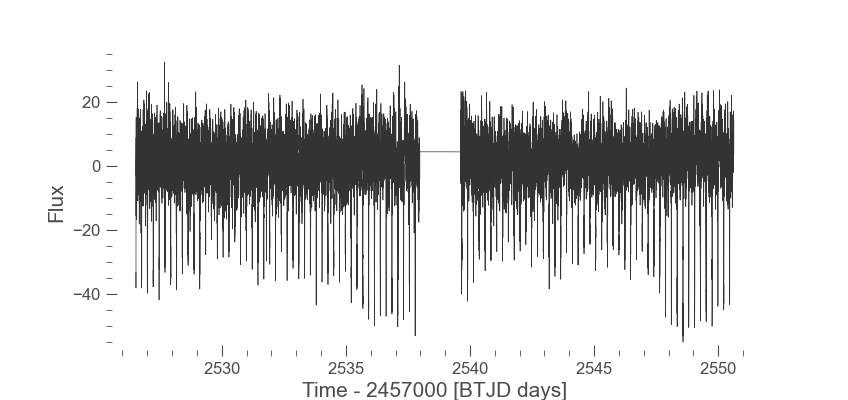

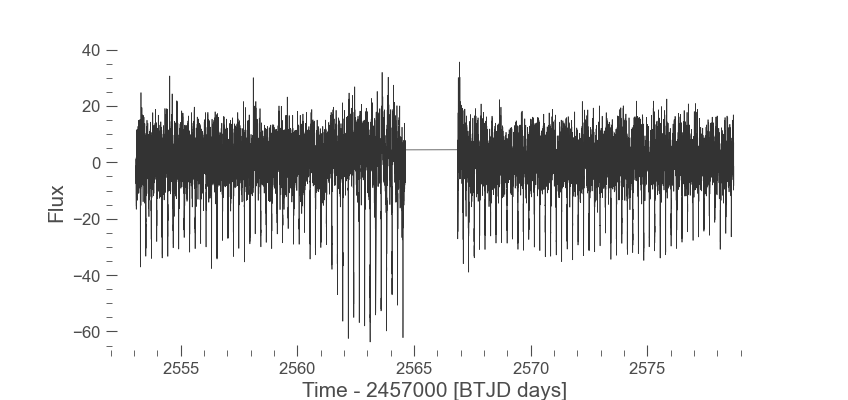

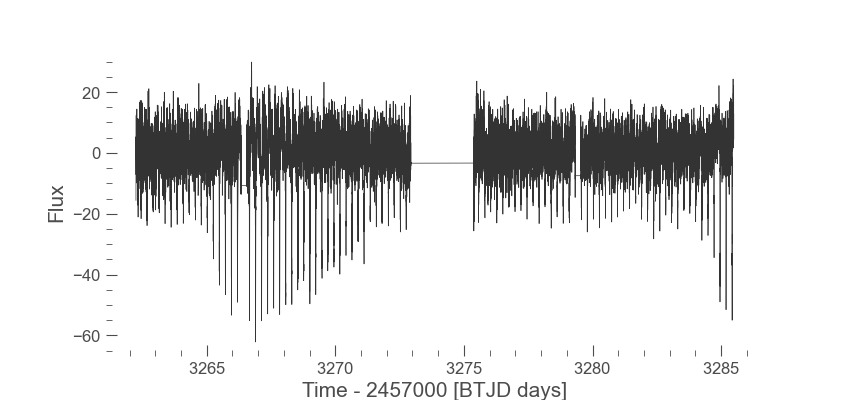

In [3]:
new_lcs = []

for lc in lcs:
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=1500)
    new_lc = straight_lines(new_lc, cadence_magnifier= 20)
    new_lcs.append(new_lc)
    new_lc.plot()

In [4]:
lightcurve = combine_lightcurves(new_lcs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426880 entries, 0 to 1426879
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1426880 non-null  float64
 1   flux    1426880 non-null  float64
dtypes: float64(2)
memory usage: 21.8 MB
None
Index         132
time     11415040
flux     11415040
dtype: int64


<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

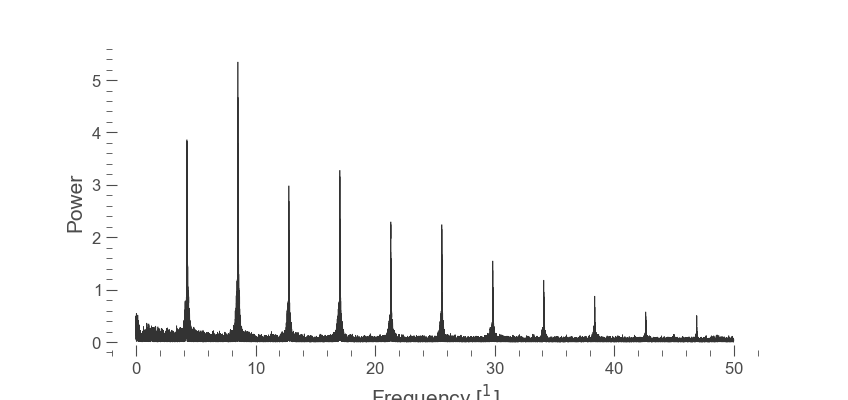

In [5]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 50)
periodogram.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

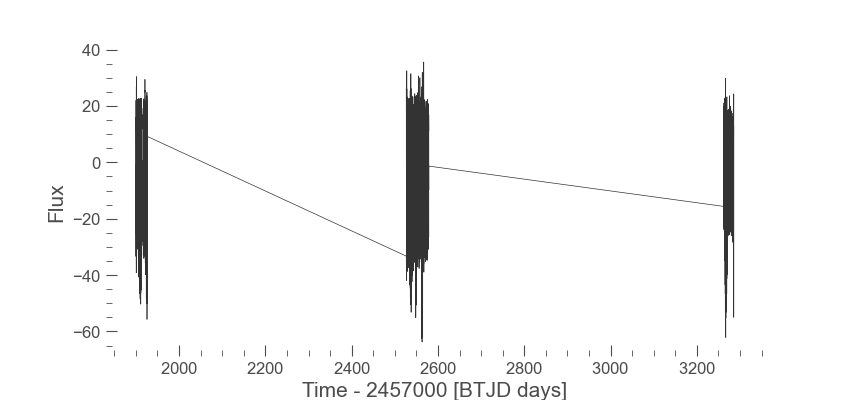

In [6]:
lightcurve.plot()

Peak's index: 29536
Predicted Amplitude: 3.860943297371097
Predicted Central Frequency: 4.264051776121422
Predicted width: 0.0007218153123406951
Fitted Amplitude: 0.799542900697668
Fitted Central Frequency: 4.2765186925778895
Fitted Standard Deviation: 0.12369744307261202


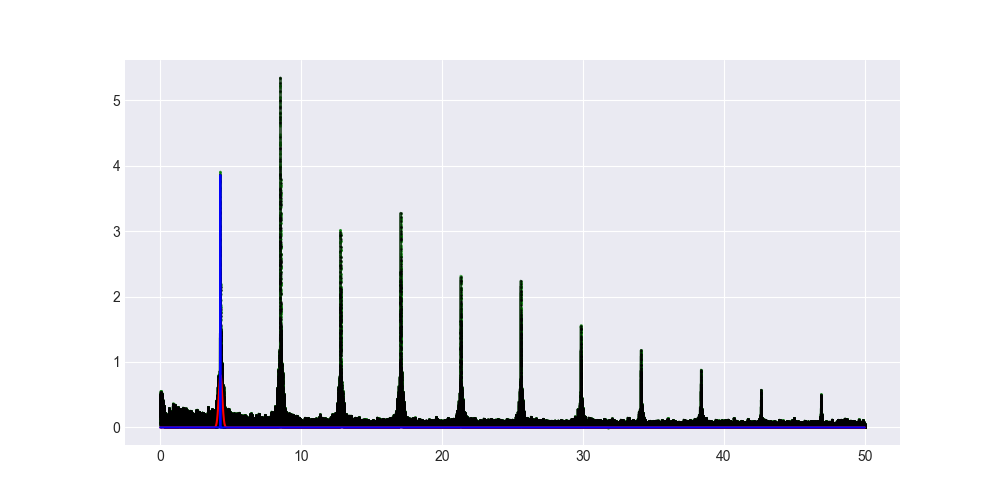

In [7]:
frequencies = periodogram.frequency.value
power = periodogram.power.value

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

pd.DataFrame({'frequencies': frequencies, 'power': power})

f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, pdict = signal.find_peaks(power, height= 3.8)

first_pick = (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0])

initial_guess = [pdict['peak_heights'][0], frequencies[peaks][0], 0.5/first_pick] 

optimized_parameters, covariance = optimize.curve_fit(gaussian, f, p, p0=initial_guess)

amp, cen, wid = optimized_parameters

fitted_gaussian = gaussian(f, amp, cen, wid)

another_gaussian = gaussian(f, pdict['peak_heights'][0], frequencies[peaks][0], 0.5/first_pick)

plt.figure(figsize=(10, 5))

plt.plot(f, p, label='Periodogram', marker='o', markersize=1, alpha=0.5, color='green')
plt.plot(frequencies, power, label='Periodogram', marker='o', markersize=1, alpha=0.5, color='black')
plt.plot(f, fitted_gaussian, label='Fitted Gaussian', color='red')
plt.plot(f, another_gaussian, label='Another Gaussian', color='blue')

print(f"Peak's index: {peaks[0]}")
print(f"Predicted Amplitude: {pdict['peak_heights'][0]}")
print(f'Predicted Central Frequency: {frequencies[peaks][0]}')
print(f"Predicted width: {1/first_pick}")

print(f'Fitted Amplitude: {amp}')
print(f'Fitted Central Frequency: {cen}')
print(f'Fitted Standard Deviation: {wid}')


#NOTES
#Standard Deviation : It's half of the width
#The green fit it's an interpolation of the periodogram (it's adding more points so we can get a more accurate fit)

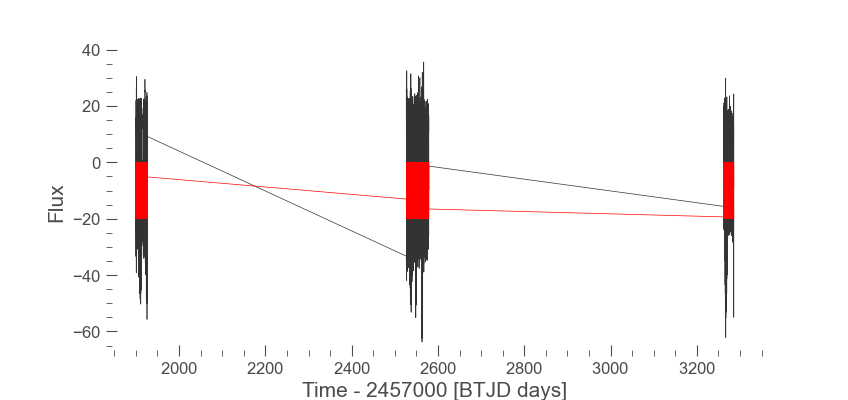

In [8]:
def sin_fit(x, amp, freq, phase, offset):
    return amp * np.sin(2 * np.pi * freq * (x - phase)) + offset

t = lightcurve.time.btjd
f = lightcurve.flux

s = sin_fit(t, 10, cen, 0.0611, -10)

ax = lightcurve.plot()
ax.plot(t, s, color='red', linewidth = 0.5)

<Axes: xlabel='Phase [JD]', ylabel='Flux'>

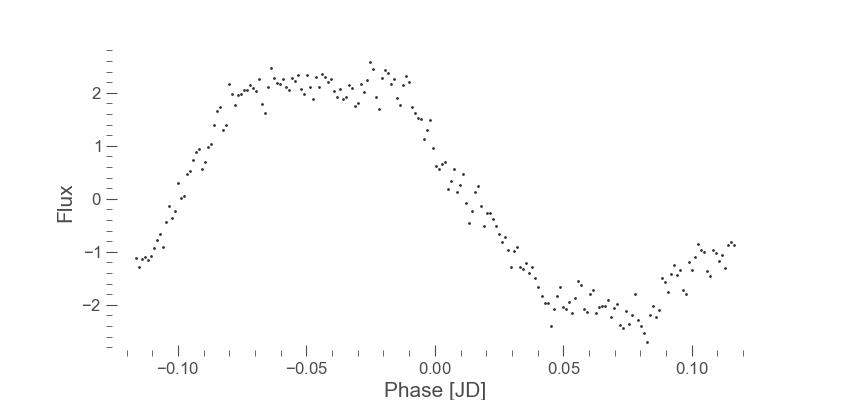

In [9]:
bin_num = 200
period = 1/cen
lightcurve.fold(period).bin(time_bin_size = period/bin_num).scatter()

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 22 2020   SPOC     120    61285257      0.0
  1 TESS Sector 45 2021   SPOC     120    61285257      0.0


<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

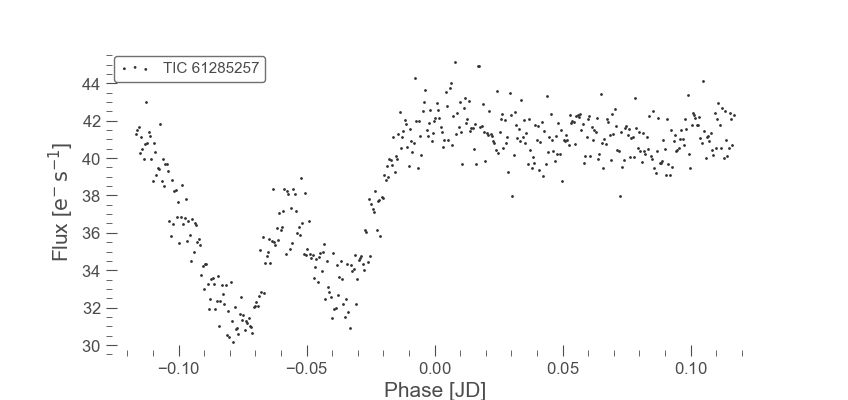

In [10]:
l = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=2)
l[0].fold(period).bin(time_bin_size = 0.0005).scatter()

In [11]:
1/4.2765186925778895

0.23383505881443933